# PyMC3 test double tanh

Fit the following harmonic model with a trend to some test data with noise,

$$
 \rho(z) = \beta_{0} - \beta_{1}\, \left(\text{tanh} \left(\frac{z + \beta_{2}} {\beta_{3}} \right) 
      + \, \text{tanh} \left(\frac{z + \beta_{2} + \beta_{4}} {\beta_{5}} \right) \right).
$$

Largely following this example [https://am207.github.io/2017/wiki/Lab7_bioassay.html#setting-up-the-model-in-pymc3](https://am207.github.io/2017/wiki/Lab7_bioassay.html#setting-up-the-model-in-pymc3)

This notebook shows show to do the following:

 - Fit a linear model with no time dependence
 - Fit a linear model with time-dependence
 - Fit a nonlinear model with time dependence (double-tanh model)
 - Fit a nonlinear model with time dependence (double-tanh model)
 
We also show various features of the `PyMC3` library.

# Inference step

See the documentation for a list of step methods (Metropolis, Hamiltonian MC): [https://docs.pymc.io/api/inference.html](https://docs.pymc.io/api/inference.html)
 

# Bayesian Hierarchical Model

(Stolen from Manderson, et al, ...)

$$
  \pmb{y}_{t}(z) = \beta_{0, t} - \beta_{1, t}\, \left(\text{tanh} \left(\frac{\pmb{z}_{t} + \beta_{2, t}} {\beta_{3, t}} \right) 
      + \, \text{tanh} \left(\frac{\pmb{z}_{t} + \beta_{2, t} + \beta_{4, t}} {\beta_{5, t}} \right) \right) + \pmb{\varepsilon}_{t},
$$

These are our regression parameters:

$$
    \pmb{\beta_{0}} \sim \text{N}\left(\mu_{\beta_{0}}, \sigma^2_{\beta_{0}} \right) \quad
    \pmb{\beta}_{1} \sim \text{N} \left(\mu_{\beta_{1}}, \sigma^2_{\beta_{1}}\right) \quad
    \pmb{\beta}_{0}, \, \pmb{\beta}_{1} > 0, \\
    \pmb{\beta}_{3} \sim \text{N} \left(\mu_{\beta_{3}}, \sigma^2_{\beta_{3}}\right) \quad
    \pmb{\beta}_{5} \sim \text{N} \left(\mu_{\beta_{5}}, \sigma^2_{\beta_{5}}\right) \qquad \pmb{\beta}_{3}, \, \pmb{\beta}_{5} > 0,\\
    \pmb{\beta}_{2} \sim \text{N} \left(\mu_{\beta_{2}}, \sigma^2_{\beta_{2}}\right) \quad
    \pmb{\beta}_{4} \sim \text{N} \left(\mu_{\beta_{4}}, \sigma^2_{\beta_{4}}\right) \qquad 0 < \pmb{\beta}_{2} < \pmb{\beta}_{4},\\
$$
where $\pmb{\beta_{0}} = (\beta_{0,1},~\beta_{0,2},~...~,~\beta_{0,T})$, and similarly   for all other regression parameters.

The priors for our means ($\mu_{\beta}$'s) are:

$$
 \mu_{\beta_{0}} \sim \text{N}(1025, 10^2) \qquad \qquad 
    \mu_{\beta_{1}} \sim \text{N} (5 , 2^2)  \qquad \qquad
    \mu_{\beta_{0}}, \, \mu_{\beta_{1}} > 0 \\
    \mu_{\beta_{3}} \sim \text{N} (80, 15^2) \qquad \mu_{\beta_{5}} \sim \text{N} (80, 15^2)  \qquad \qquad
    \mu_{\beta_{3}}, \, \mu_{\beta_{5}} > 0 \\
    \mu_{\beta_{2}} \sim \text{N} (75, 15^2) \qquad \mu_{\beta_{4}} \sim \text{N} (150, 15^2) \qquad \qquad 
    0 < \mu_{\beta_{2}} < \mu_{\beta_{4}}
$$

Note that our means even have a distribution !!??!!
The density profile at a specific time $t$ is a deviation from this mean. Our goal is to estimate the mean values of our $\beta$ parameters (and their distributions) across all time points.

If we were to use just a single time point, the mean and variance would be a single value rather than a distribution of points.

# Initialise the python packages

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import fmin_powell, fmin, fmin_cg, fmin_ncg
import seaborn as sns

from theano import shared
from theano import tensor as tt

import matplotlib as mpl
sns.set()

%matplotlib inline

mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 'large'

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import pdb
# Our model functions
def double_tanh_pm(beta, z):
    """
    Double-tanh function that accepts PyMC3 objects instead of numpy arrays
    """
    fac1 = (z+beta[2])/beta[3]
    fac2 = (z+beta[2]+beta[4])/beta[5]
    return beta[0] - beta[1]*( pm.math.tanh(fac1)
                + pm.math.tanh(fac2))

def double_tanh(beta, z):
    
    return beta[0] - beta[1]*(np.tanh((z+beta[2])/beta[3])
                + np.tanh((z+beta[2]+beta[4])/beta[5]))

def single_tanh_pm(beta, z):
    """
    Double-tanh function that accepts PyMC3 objects instead of numpy arrays
    """
    fac1 = (z+beta[2])/beta[3]
    
    return beta[0] - beta[1]*pm.math.tanh(fac1)

def single_tanh(beta, z):
    return beta[0] - beta[1]*np.tanh((z+beta[2])/beta[3])
                              
def linear(beta_s, z):
    
    result = beta_s[0] + beta_s[1] * z
    return result
    

# Load the density data from a csv file

In [26]:
from datetime import datetime
# Load some density data
csvfile = '/home/suntans/Share/ARCHub/DATA/FIELD/IMOS/IMOS_Density_KIM200_2013_a.csv'
zmin = -202.5

csvfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/Crux_KP150_Phs2_Density_lowpass.csv'
zmin = -252.5

def convert_time(tt):
    try:
        dt= datetime.strptime(tt, '%Y-%m-%dT%H:%M:%S')
    except:
        dt= datetime.strptime(tt, '%Y-%m-%d %H:%M')
    return dt
# Reads into a dataframe object
df = pd.read_csv(csvfile, index_col=0, sep=', ', parse_dates=['Time'], date_parser=convert_time)


# Get the depths and density values out of the dataframe object
depths = np.array([float(ii) for ii in df.columns.values])
rho_obs = df[510:511].values.ravel().astype(float)

zout = np.linspace(zmin,0,50)

print(df.shape)
df.tail()
#df.index[0]

(756, 12)


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


,-250.5,-227.8,-203.6,-179.4,-155.2,-131.0,-106.8,-82.6,-58.4,-34.2,-11.7,-9.7
Time,,,,,,,,,,,,
2017-05-07 00:40:00,1026.1275,1025.9857,1025.7640,1025.4997,1025.0040,1024.0395,1023.0834,1022.4796,1022.2284,1022.1429,1022.1225,1022.1159
2017-05-07 06:40:00,1026.2333,1026.1244,1025.9153,1025.6730,1025.2302,1024.3727,1023.4708,1022.8981,1022.6705,1022.5806,1022.5608,1022.5546
2017-05-07 12:40:00,1026.3583,1026.2751,1026.0856,1025.8685,1025.4757,1024.7310,1023.9040,1023.3750,1023.1714,1023.0813,1023.0626,1023.0568
2017-05-07 18:40:00,1026.4791,1026.4135,1026.2444,1026.0510,1025.7012,1025.0540,1024.3053,1023.8223,1023.6402,1023.5535,1023.5362,1023.5310
2017-05-08 00:40:00,1026.5696,1026.5139,1026.3599,1026.1837,1025.8644,1025.2837,1024.5956,1024.1492,1023.9828,1023.9004,1023.8843,1023.8795


Text(0.5,0,'$\\rho$ [kg m$^{-3}$]')

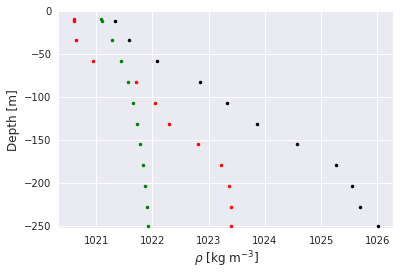

In [4]:
# Plot of the data
plt.figure()
plt.plot(rho_obs[:-1], depths[:-1], 'k.')
plt.plot(double_tanh([1022,0.7, 70.,20.,80.,30.], depths),depths,'r.')

plt.plot(1022-np.exp(depths/100),depths,'g.')

#plt.plot(linear([1020,-0.007], depths),depths,'b.')

plt.ylim(zmin,0 )
plt.ylabel('Depth [m]')
plt.xlabel(r'$\rho$ [kg m$^{-3}$]')
#depths, rho_obs

# Example of simple linear model fit

We demonstrate the basic procedure for conducting Bayesian inference using a linear model for density to begin with

$$
\rho(z) = \beta_0 + \beta_1  z
$$

In [46]:
def lin_model(beta, x):
    return beta[0] + beta[1]*x

with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfNormal('sigma', 1)
    beta_0 = pm.Normal('beta_0', 1020, sd=1)
    beta_1 = pm.Normal('beta_1', 0, sd=0.5)
    
    # Define likelihood
    #likelihood = pm.Normal('y', mu=intercept + x_coeff * x, sd=sigma, observed=y)
    mu_X = lin_model([beta_0, beta_1], depths)
    likelihood = pm.Normal('y', mu=mu_X, sd=sigma, observed=rho_obs)

    
    # Inference!
    start = pm.find_MAP() # Find starting value by optimization
    #step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    step = pm.HamiltonianMC(scaling=start) # Instantiate MCMC sampling algorithm

    trace = pm.sample(2000, step, progressbar=True) # draw 2000 posterior samples using NUTS sampling
    
model

logp = -4.6616, ||grad|| = 3,257: 100%|██████████| 40/40 [00:00<00:00, 2328.45it/s]   
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [beta_1, beta_0, sigma_log__]
100%|██████████| 2500/2500 [00:00<00:00, 2905.10it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [13]:
# Summary statistics of the output parameters
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_0,1021.041151,0.125404,0.007423,1020.794811,1021.285115,164.103406,1.016858
beta_1,-0.021288,0.000856,0.000051,-0.022963,-0.019557,159.941369,1.015862
sigma,0.251000,0.064434,0.001737,0.145307,0.376229,1139.065209,1.002935


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbfd7bec18>,
      dtype=object)

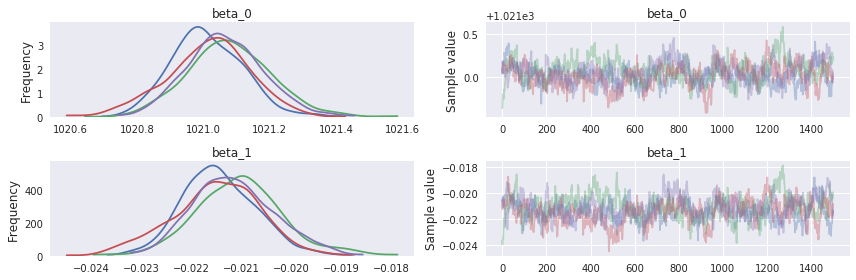

In [14]:
pm.traceplot(trace[500:], varnames=['beta_0','beta_1'])

In [15]:
# Convert the trace to a DataFrame (save to netcdf, hdf, etc)
df_tr = pm.backends.tracetab.trace_to_dataframe(trace, chains=0)
df_tr.head()

,beta_0,beta_1,sigma
0,1021.290100,-0.019770,0.181572
1,1021.207887,-0.019701,0.217547
2,1021.231489,-0.020721,0.210892
3,1021.104252,-0.020479,0.229517
4,1021.111369,-0.020308,0.234996


# Plot some predictions

In [16]:
# Plot the uncertainty bounds of the estimated data

# Get samples like this...

#ppc = pm.sample_ppc(trace, model=model, vars=[beta_0,beta_1], samples=500)
ppc = pm.sample_ppc(trace, model=model, samples=500)


# Extract the "y"
#ppc = pm.sample_ppc(trace, model=model, samples=500)

#rho_est = ppc.values


100%|██████████| 500/500 [00:00<00:00, 2073.47it/s]


In [25]:
# Generate an output plot with 500 samples overlaid

#for beta_0, beta_1 in zip(ppc['beta_0'], ppc['beta_1']):
#    rhotmp = lin_model([beta_0, beta_1], zout)
#    plt.plot(rhotmp, zout, '0.5', lw=0.2, alpha=0.5)

for ii in range(500):
    plt.plot(ppc['y'][ii,:], depths, '0.5', lw=0.2, alpha=0.5)

plt.plot(rho_obs, depths, 'k.')

NameError: name 'ppc' is not defined

In [18]:
# Get the mean and quantiles of the model parameters

def trace_sd(x):
    return pd.Series(np.std(x, 0), name='sd')
def trace_mean(x):
    return pd.Series(np.mean(x, 0), name='mean')
def trace_quantiles(x):
    return pd.DataFrame(pm.quantiles(x, [5, 50, 95]))

params = pm.summary(trace, stat_funcs=[trace_mean, trace_sd, trace_quantiles])
params

,mean,sd,5,50,95
beta_0,1021.041151,0.125404,1020.838763,1021.038553,1021.252080
beta_1,-0.021288,0.000856,-0.022637,-0.021315,-0.019830
sigma,0.251000,0.064434,0.169426,0.240832,0.369584


Text(0.5,0,'$\\rho$ [kg m$^{-3}$]')

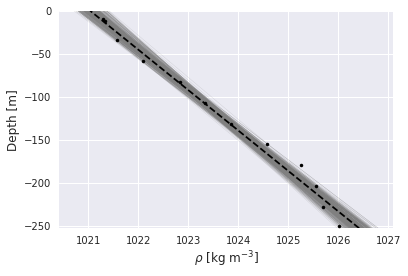

In [19]:
rhomean = lin_model([params['mean']['beta_0'], params['mean']['beta_1']], zout)

#plt.plot(rhomean, zout, 'k--',)

#plt.fill_betweenx(depths, \
#        ppc['y'].mean(axis=0)- ppc['y'].std(axis=0),\
#        ppc['y'].mean(axis=0)+ppc['y'].std(axis=0),
#        color='0.5',alpha=0.2)

#def my_model(x,y):
#    return lin_model([y['beta_0'],y['beta_1']],x)
#pm.plot_posterior_predictive_glm(trace, eval=zout, lm=my_model)
samples = 500
for rand_loc in np.random.randint(0, len(trace), samples):
    rs = trace[rand_loc]
    rhotmp = lin_model([rs['beta_0'], rs['beta_1']], zout)
    plt.plot(rhotmp, zout, '0.5', lw=0.2, alpha=0.5)
    
plt.plot(rho_obs,depths, 'k.')
plt.plot(rhomean, zout, 'k--',) # Mean fit

plt.ylim(zmin,0 )
plt.ylabel('Depth [m]')
plt.xlabel(r'$\rho$ [kg m$^{-3}$]')

 How to randomly sample from a trace
 
 See:
 https://github.com/pymc-devs/pymc3/blob/master/pymc3/plots/posteriorplot.py#L151

In [20]:
samples = 1
for rand_loc in np.random.randint(0, len(trace), samples):
    rand_sample = trace[rand_loc]
rand_sample



{'beta_0': 1021.0408088460297,
 'beta_1': -0.021362270913792985,
 'sigma': 0.20942988040823232,
 'sigma_log__': -1.5633662953664393}

# "Time-varying" linear regression case

(12,) (12,) 200


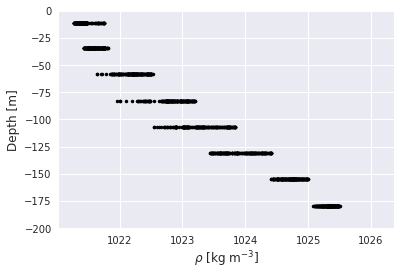

In [5]:
# Load data points 510 --> 530
start = 550
end = 750
idx = [20,300,750]

depths= np.array([float(ii) for ii in df.columns.values])
rho_obs_tmp = df[start:end].values.astype(float)
time = df.index[start:end]
#rho_obs_tmp = df.iloc[idx].values.astype(float)
#time = df.index[idx]

# Clip the top
rho_obs_2d = rho_obs_tmp[:,:-1]

# Remove some nan
fill_value = 1024.
rho_obs_2d[np.isnan(rho_obs_2d)] = fill_value

nt,nz = rho_obs_2d.shape

depths_2d = depths[np.newaxis,:-1].repeat(nt, axis=0)

#
plt.plot(rho_obs_2d.ravel(), depths_2d.ravel(), 'k.')

plt.ylim(-200,0 )
plt.ylabel('Depth [m]')
plt.xlabel(r'$\rho$ [kg m$^{-3}$]')

print(rho_obs.shape, depths.shape, nt)

In [6]:
rho_obs_tmp = df.loc

Text(0.5,0,'Date [yyyy-mm]')

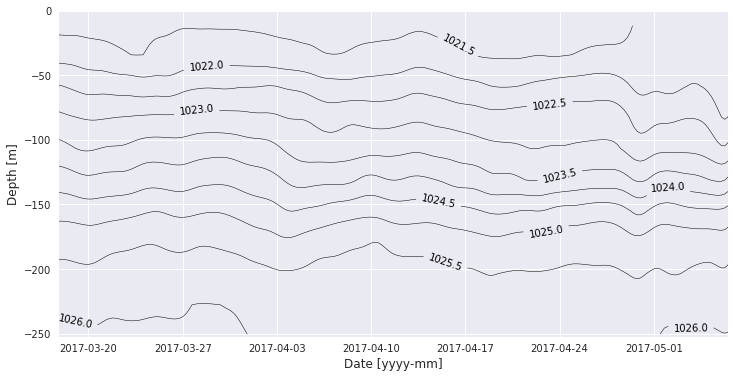

In [7]:
plt.figure(figsize=(12,6))
#cf = plt.contour(range(nt), depths, rho_obs_2d.T, np.arange(1020,1030,0.5), colors='k', linewidths=0.5)
cf = plt.contour(time, depths_2d.T[:,0], rho_obs_2d.T, np.arange(1020,1030,0.5), colors='k', linewidths=0.5)


plt.clabel(cf, fmt='%3.1f')

plt.ylim(zmin,0)
plt.ylabel('Depth [m]')
plt.xlabel('Date [yyyy-mm]')

#plt.savefig('pymc3_crux_isolines.png')
#plt.savefig('pymc3_crux_isolines.pdf')

Note the following for the time-varying case

  - Extra parameters, `mu_beta_n`, that store the distribution of beta
  - `shape` argument allows us to input time-varying data

In [61]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    nparams=2
    #sigma_curve = pm.HalfNormal('sigma_curve', sd=20, shape=(nt,))
    #sigma_beta = pm.HalfNormal('sigma_beta',  sd=15.0, shape=(nt,))
    sigma_curve = pm.HalfNormal('sigma_curve', sd=10, )
    sigma_beta = pm.HalfNormal('sigma_beta',  sd=1.0, shape=(nparams,))

    
    mu_betas = dict(
        #mu_beta_0 = pm.Normal('mu_beta_0', 1020, sd=2 , shape=(nt,)),
        #mu_beta_1 = pm.Normal('mu_beta_1', 0, sd=0.5, shape=(nt,))
        mu_beta_0 = pm.Normal('mu_beta_0', 1020, sd=10. ),
        mu_beta_1 = pm.Normal('mu_beta_1', 0, sd=1.)
    )

    #beta_s = []
    #for ii in range(2):
    #    beta_s.append(pm.Normal('beta_%d'%ii,\
    #        mu=mu_betas['mu_beta_%d'%ii], sd=sigma_beta[ii], shape=(nt,1)))
    
    # Define likelihood
    #mu_X = lin_model(beta_s, depths_2d)
    #likelihood = pm.Normal('y', mu=mu_X, sd=sigma_curve, observed=rho_obs_2d, shape=(nt,1))
    
    beta_s = []
    for ii in range(2):
        beta_s.append(pm.Normal('beta_%d'%ii,\
            mu=mu_betas['mu_beta_%d'%ii], sd=sigma_beta[ii], shape=nt))
    
    # Define likelihood
    mu_X = lin_model(beta_s, depths_2d.T)
    likelihood = pm.Normal('y', mu=mu_X, sd=sigma_curve, observed=rho_obs_2d.T,)


    
    # Inference!
    #start = pm.find_MAP() # Find starting value by optimization
    #start=None
    #step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    #step = pm.HamiltonianMC()
    #step = pm.NUTS(target_accept=0.99)
    step=None
    trace = pm.sample(1000, tune=1900, step=step)
    #trace = pm.fit()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_1, beta_0, mu_beta_1, mu_beta_0, sigma_beta_log__, sigma_curve_log__]

  9%|▉         | 273/2900 [00:28<04:35,  9.55it/s]


 37%|███▋      | 1066/2900 [00:50<01:26, 21.13it/s]


 65%|██████▌   | 1885/2900 [01:11<00:38, 26.45it/s]


100%|██████████| 2900/2900 [01:13<00:00, 39.71it/s]The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.05626605561122036, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.03944401925541094, but should be close to 0.8. Try to increase the number of tuning steps.
There were 271 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.40990941751018967, but should be close to 0.8. Try to increase the number of tuning steps.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for 

Summary statistics of the output parameters

Note that each of our mu_betas and betas have a subscript now


In [62]:
pm.fit?

In [63]:
model

In [64]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_beta_0,1021.102257,0.009411,0.000685,1021.081491,1021.120184,12.928924,1.161980
mu_beta_1,-0.021231,0.000059,0.000005,-0.021384,-0.021131,8.785383,1.242865
beta_0__0,1021.181669,0.050880,0.002955,1021.096888,1021.296177,20.989536,1.092290
beta_0__1,1021.173177,0.053402,0.003065,1021.091447,1021.297383,8.149050,1.187168
beta_0__2,1021.221743,0.065686,0.005144,1021.083758,1021.293774,3.752540,1.534799
beta_0__3,1021.178814,0.044948,0.001953,1021.070965,1021.272976,125.615058,1.040212
beta_0__4,1021.173553,0.052671,0.003148,1021.065626,1021.271838,17.193653,1.122525
beta_0__5,1021.150387,0.065983,0.005287,1021.062676,1021.261233,3.876874,1.504947
beta_0__6,1021.176851,0.052481,0.003334,1021.055508,1021.262486,10.407630,1.171285
beta_0__7,1021.181596,0.063195,0.004674,1021.047159,1021.255391,4.832495,1.370453


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdba44f4860>,
      dtype=object)

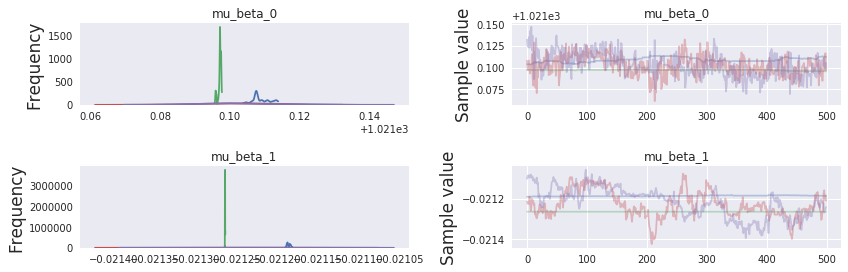

In [65]:
pm.traceplot(trace[500:], varnames=['mu_beta_0','mu_beta_1'])

In [66]:
# Plot the uncertainty bounds of the estimated data

# Get samples like this...
nsamples = 500
ppc = pm.sample_ppc(trace, model=model, vars=[mu_betas['mu_beta_0'], mu_betas['mu_beta_1']], samples=nsamples)



100%|██████████| 500/500 [00:00<00:00, 2842.63it/s]

In [67]:
df_tr = pm.backends.tracetab.trace_to_dataframe(trace,chains=0)
df_tr.head()

,mu_beta_0,mu_beta_1,beta_0__0,beta_0__1,beta_0__2,beta_0__3,beta_0__4,beta_0__5,beta_0__6,beta_0__7,...,beta_1__193,beta_1__194,beta_1__195,beta_1__196,beta_1__197,beta_1__198,beta_1__199,sigma_curve,sigma_beta__0,sigma_beta__1
0,1021.105953,-0.021186,1021.146468,1021.151458,1021.27011,1021.218119,1021.115205,1021.116849,1021.228063,1021.204049,...,-0.021183,-0.021186,-0.021191,-0.021187,-0.021156,-0.021182,-0.021182,0.286449,0.09774,0.000013
1,1021.105953,-0.021186,1021.146468,1021.151458,1021.27011,1021.218119,1021.115205,1021.116849,1021.228063,1021.204049,...,-0.021183,-0.021186,-0.021191,-0.021187,-0.021156,-0.021182,-0.021182,0.286449,0.09774,0.000013
2,1021.105953,-0.021186,1021.146468,1021.151458,1021.27011,1021.218119,1021.115205,1021.116849,1021.228063,1021.204049,...,-0.021183,-0.021186,-0.021191,-0.021187,-0.021156,-0.021182,-0.021182,0.286449,0.09774,0.000013
3,1021.105953,-0.021186,1021.146468,1021.151458,1021.27011,1021.218119,1021.115205,1021.116849,1021.228063,1021.204049,...,-0.021183,-0.021186,-0.021191,-0.021187,-0.021156,-0.021182,-0.021182,0.286449,0.09774,0.000013
4,1021.105953,-0.021186,1021.146468,1021.151458,1021.27011,1021.218119,1021.115205,1021.116849,1021.228063,1021.204049,...,-0.021183,-0.021186,-0.021191,-0.021187,-0.021156,-0.021182,-0.021182,0.286449,0.09774,0.000013


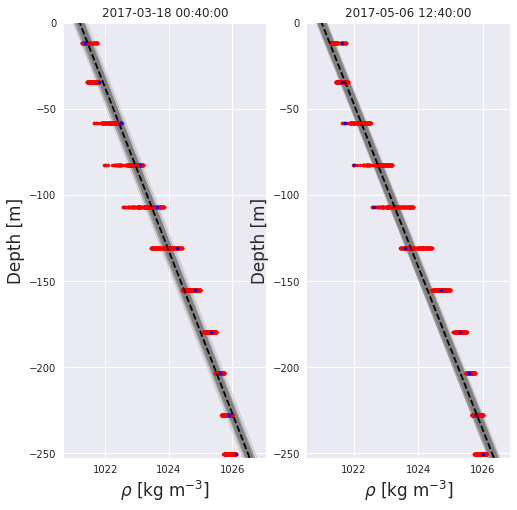

In [68]:
tstep = -1
#rhomean = double_tanh([params['mean']['beta_%d__%d'%(ii,tstep)] for ii in range(6)], zout)
def plotstep(tstep):
    rhomean = np.zeros_like(zout)



    samples = 500
    for rand_loc in np.random.randint(0, len(trace), samples):
        rs = trace[rand_loc]
        rhotmp = lin_model([rs['beta_%d'%ii][tstep] for ii in range(2)], zout)
        plt.plot(rhotmp, zout, '0.5', lw=0.2, alpha=0.5)

        rhomean+=rhotmp

    plt.plot(rho_obs_2d, depths_2d, 'r.')
    plt.plot(rho_obs_2d[tstep,:],depths_2d[tstep,:], 'b.')


    rhomean /= samples
    plt.plot(rhomean, zout, 'k--',) # Mean fit

    plt.ylim(zmin,0 )
    plt.ylabel('Depth [m]')
    plt.xlabel(r'$\rho$ [kg m$^{-3}$]')
    plt.title(time[tstep])

plt.figure(figsize=(8,8))
plt.subplot(121)
plotstep(1)

plt.subplot(122)
plotstep(-1)



# Double tanh fit

First we fit with just one time step

In [19]:
tstep = -1
RHO0 = 1.
H0 = 1.
# Constant time model
with pm.Model() as rho_model:
    ###
    # Create priors for each of our mean
    # Mean
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    # Use a dictionary so we can look up the parameters easily
    betas = [
        pm.Normal('beta_0', mu=1025.0/RHO0, sd=10.0/RHO0),
        BoundedNormal('beta_1', mu=5./RHO0, sd=2./RHO0),
        #pm.Normal('beta_2', mu=75.0/H0, sd=15.0/H0),
        #pm.Normal('beta_3', mu=80.0/H0, sd=15.0/H0),
        #BoundedNormal('beta_4', mu=75.0/H0, sd=15.0/H0),
        #pm.Normal('beta_5', mu=80.0/H0, sd=15.0/H0),
        BoundedNormal('beta_2', mu=75.0/H0, sd=15.0/H0),
        BoundedNormal('beta_3', mu=80.0/H0, sd=15.0/H0),
        BoundedNormal('beta_4', mu=0.0/H0, sd=15.0/H0),
        BoundedNormal('beta_5', mu=40.0/H0, sd=15.0/H0),
    ]
    
    sigma_beta = pm.HalfNormal('sigma_beta',sd=2./RHO0)
        
    ###
    # Generate the likelihood function using the deterministic variable as the mean
    mu_x = double_tanh_pm(betas, depths_2d[tstep,:]/H0)
    
    rho = pm.Normal('rho', mu=mu_x, sd=sigma_beta, observed=rho_obs_2d[tstep,:]/RHO0)
    
    # Inference step...
    #start = pm.find_MAP()
    start = None
    #scaling = pm.find_hessian(start)
    #scaling=start
    #step = pm.HamiltonianMC(scaling=scaling)

    #step = pm.NUTS(scaling=start)
    #step = pm.NUTS(target_accept=0.99, step_scale=0.25, is_cov=False, integrator='leapfrog')
    #step = pm.Metropolis()
    #trace = pm.sample(1000, tune=20000, step = pm.Metropolis(target_accept=0.95), cores=2)
    #trace = pm.sample(1000, tune=900, step = step ,)
    trace = pm.sample(1000)

    
#rho_model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_beta_log__, beta_5_lowerbound__, beta_4_lowerbound__, beta_3_lowerbound__, beta_2_lowerbound__, beta_1_lowerbound__, beta_0]
100%|██████████| 1500/1500 [00:12<00:00, 119.06it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9017586153415525, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [20]:
params = pm.summary(trace)
params

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_0,1023.665664,0.075642,0.002311,1023.507900,1023.796881,957.534836,1.002230
beta_1,1.163236,0.050584,0.001337,1.072735,1.266263,1292.874538,0.999846
beta_2,120.654290,8.308841,0.269607,104.211902,135.095401,870.585176,1.000909
beta_3,80.626481,15.799593,0.438333,47.394231,109.205105,1227.500755,0.999674
beta_4,17.168974,10.120487,0.295444,0.012715,35.532212,1065.330153,0.999831
beta_5,36.605486,6.541717,0.162626,24.630875,49.770759,1593.805824,0.999521
sigma_beta,0.111710,0.047533,0.001560,0.046393,0.197574,935.587687,1.004711


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0920691438>,
      dtype=object)

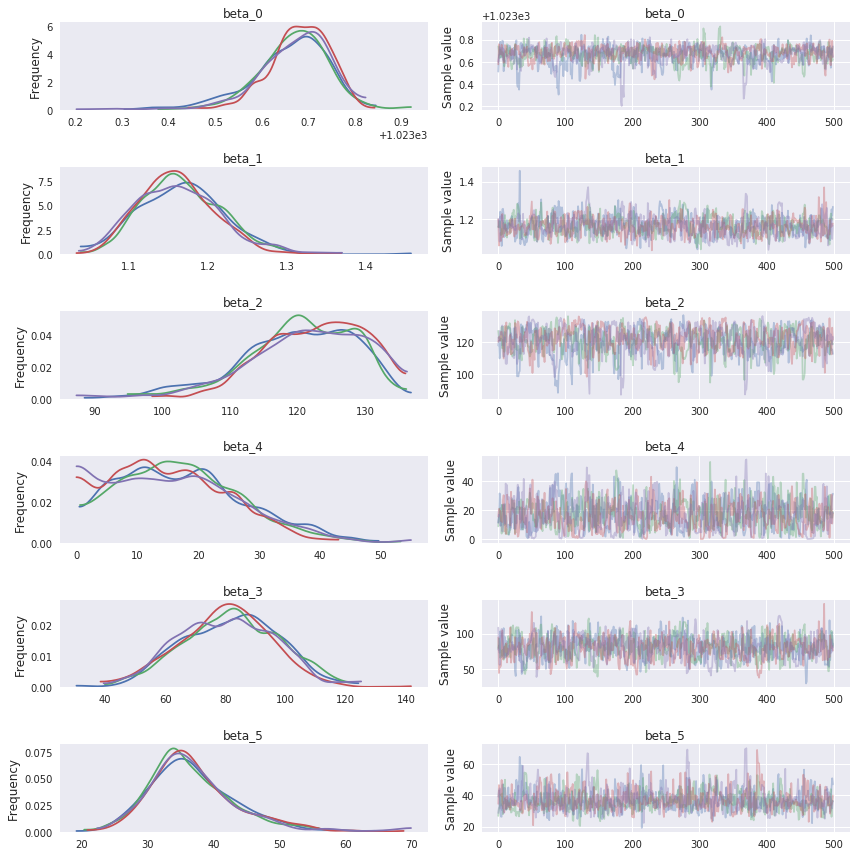

In [21]:
# Trace plot of some parameters
pm.traceplot(trace[500:], varnames=['beta_0','beta_1','beta_2','beta_4','beta_3','beta_5'])


Text(0.5,0,'$\\rho$ [kg m$^{-3}$]')

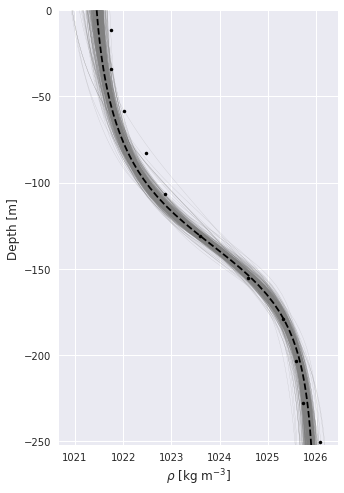

In [27]:
rhomean = double_tanh([params['mean']['beta_%d'%ii] for ii in range(6)], zout/H0)

#plt.plot(rhomean, zout, 'k--',)

#plt.fill_betweenx(depths, \
#        ppc['y'].mean(axis=0)- ppc['y'].std(axis=0),\
#        ppc['y'].mean(axis=0)+ppc['y'].std(axis=0),
#        color='0.5',alpha=0.2)

#def my_model(x,y):
#    return lin_model([y['beta_0'],y['beta_1']],x)
#pm.plot_posterior_predictive_glm(trace, eval=zout, lm=my_model)

plt.figure(figsize=(5,8))
samples = 500
for rand_loc in np.random.randint(0, len(trace), samples):
    rs = trace[rand_loc]
    rhotmp = double_tanh([rs['beta_%d'%ii] for ii in range(6)], zout/H0)
    plt.plot(rhotmp*RHO0, zout, '0.5', lw=0.2, alpha=0.5)
    
plt.plot(rho_obs_2d[tstep,:],depths_2d[tstep,:], 'k.')
plt.plot(rhomean*RHO0, zout, 'k--',) # Mean fit

plt.ylim(zmin,0 )
plt.ylabel('Depth [m]')
plt.xlabel(r'$\rho$ [kg m$^{-3}$]')

# Time-independent (vectorized) model

See here: [github.com/pymc-devs/pymc3/issues/1051](https://github.com/pymc-devs/pymc3/issues/1051)




In [8]:
depths_2d[0,:,np.newaxis]

array([[-250.5],
       [-227.8],
       [-203.6],
       [-179.4],
       [-155.2],
       [-131. ],
       [-106.8],
       [ -82.6],
       [ -58.4],
       [ -34.2],
       [ -11.7]])

In [39]:
# Constant time model
with pm.Model() as rho_model:
    ###
    # Create priors for each of our mean
    # Mean
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    # Use a dictionary so we can look up the parameters easily
    betas = [
        pm.Normal('beta_0', mu=1025.0/RHO0, sd=10.0/RHO0, shape=(nt,)),
        BoundedNormal('beta_1', mu=5./RHO0, sd=2./RHO0, shape=(nt,)),
        #pm.Normal('beta_2', mu=75.0/H0, sd=15.0/H0),
        #pm.Normal('beta_3', mu=80.0/H0, sd=15.0/H0),
        #BoundedNormal('beta_4', mu=75.0/H0, sd=15.0/H0),
        #pm.Normal('beta_5', mu=80.0/H0, sd=15.0/H0),
        BoundedNormal('beta_2', mu=75.0/H0, sd=15.0/H0, shape=(nt,)),
        BoundedNormal('beta_3', mu=80.0/H0, sd=15.0/H0, shape=(nt,)),
        BoundedNormal('beta_4', mu=0.0/H0, sd=15.0/H0, shape=(nt,)),
        BoundedNormal('beta_5', mu=40.0/H0, sd=15.0/H0, shape=(nt,)),
    ]
    
    sigma_beta = pm.HalfNormal('sigma_beta',sd=2./RHO0)
    #sigma_beta = pm.HalfNormal('sigma_beta',sd=2./RHO0)

        
    ###
    # Generate the likelihood function using the deterministic variable as the mean
    mu_x = double_tanh_pm(betas, depths_2d[0,:,np.newaxis]/H0)
    
    rho = pm.Normal('rho', mu=mu_x, sd=sigma_beta, observed=rho_obs_2d.T/RHO0)
    
    # Inference step...
    #step = pm.HamiltonianMC(is_cov=True)
    #start = pm.find_MAP()
    #step = pm.NUTS(target_accept=0.80, scaling=start)
    #step = pm.NUTS(target_accept=0.99, step_scale=0.25, is_cov=False, integrator='leapfrog')
    #step = pm.Metropolis()
    #trace = pm.sample(1000, tune=12900, step = pm.Metropolis(target_accept=0.95), cores=2)
    #trace = pm.sample(1000, tune=3000, step = step )
    trace = pm.sample(1000, nuts_kwargs=dict(max_treedepth=16))

    
#rho_model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_beta_log__, beta_5_lowerbound__, beta_4_lowerbound__, beta_3_lowerbound__, beta_2_lowerbound__, beta_1_lowerbound__, beta_0]
100%|██████████| 1500/1500 [26:09<00:00,  1.05s/it]
There were 297 divergences after tuning. Increase `target_accept` or reparameterize.
There were 212 divergences after tuning. Increase `target_accept` or reparameterize.
There were 157 divergences after tuning. Increase `target_accept` or reparameterize.
There were 396 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [40]:
params = pm.summary(trace)
params[0:5]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_0__0,1023.466416,0.147712,0.004552,1023.175805,1023.769838,721.496267,1.004627
beta_0__1,1023.474200,0.147025,0.004259,1023.187360,1023.751316,1240.782974,1.001213
beta_0__2,1023.483940,0.139767,0.003660,1023.198340,1023.756007,1467.441344,1.000068
beta_0__3,1023.492968,0.140153,0.003963,1023.217345,1023.765309,1274.127028,1.002320
beta_0__4,1023.507760,0.139142,0.004146,1023.216047,1023.762279,851.197484,1.010261


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f092053fdd8>,
      dtype=object)

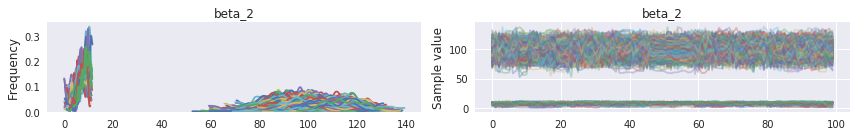

In [41]:
pm.traceplot(trace[900:], varnames=['beta_2'])

Text(0.5,1,'2017-05-06 12:40:00')

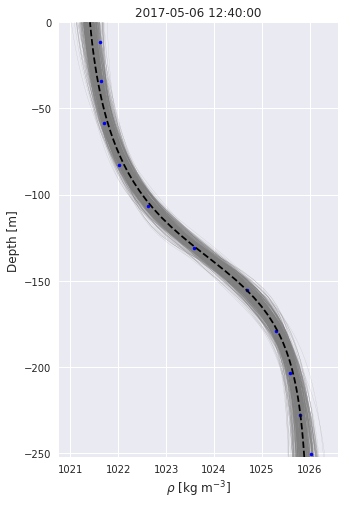

In [42]:
tstep = -1
#rhomean = double_tanh([params['mean']['beta_%d__%d'%(ii,tstep)] for ii in range(6)], zout)
rhomean = np.zeros_like(zout)

#plt.plot(rhomean, zout, 'k--',)

#plt.fill_betweenx(depths, \
#        ppc['y'].mean(axis=0)- ppc['y'].std(axis=0),\
#        ppc['y'].mean(axis=0)+ppc['y'].std(axis=0),
#        color='0.5',alpha=0.2)

#def my_model(x,y):
#    return lin_model([y['beta_0'],y['beta_1']],x)
#pm.plot_posterior_predictive_glm(trace, eval=zout, lm=my_model)

plt.figure(figsize=(5,8))
samples = 500
for rand_loc in np.random.randint(0, len(trace), samples):
    rs = trace[rand_loc]
    rhotmp = double_tanh([rs['beta_%d'%ii][tstep] for ii in range(6)], zout)
    plt.plot(rhotmp, zout, '0.5', lw=0.2, alpha=0.5)
    
    rhomean+=rhotmp
    
plt.plot(rho_obs_2d[tstep,:],depths_2d[tstep,:], 'b.')

rhomean /= samples
plt.plot(rhomean, zout, 'k--',) # Mean fit

plt.ylim(zmin,0 )
plt.ylabel('Depth [m]')
plt.xlabel(r'$\rho$ [kg m$^{-3}$]')
plt.title(time[tstep])

# Time-dependent model

Here we construct the time-dependent model i.e. where each time step has information about other time steps through the $\mu_{\beta}$ parameters.

In [35]:
# Full model
with pm.Model() as rho_model:
    ###
    # Create priors for each of our means
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    # Use a dictionary so we can look up the parameters easily
    mu_betas = dict(
        mu_beta_0 = pm.Normal('mu_beta_0', mu=1025.0, sd=10.0,),
        #mu_beta_1 = BoundedNormal('mu_beta_1', mu=5., sd=2.,),
        #mu_beta_2 = BoundedNormal('mu_beta_2', mu=45.0, sd=15.0,),
        #mu_beta_3 = pm.Normal('mu_beta_3', mu=80.0, sd=15.0,),
        #mu_beta_4 = BoundedNormal('mu_beta_4', mu=75.0, sd=15.0,),
        #mu_beta_5 = pm.Normal('mu_beta_5', mu=80.0, sd=15.0,),
        mu_beta_1 = BoundedNormal('mu_beta_1', mu=1., sd=0.5,),
        mu_beta_2 = BoundedNormal('mu_beta_2', mu=75.0, sd=15.0,),
        mu_beta_3 = BoundedNormal('mu_beta_3', mu=80.0, sd=15.0,),
        mu_beta_4 = BoundedNormal('mu_beta_4', mu=0.0, sd=15.0,),
        mu_beta_5 = BoundedNormal('mu_beta_5', mu=40.0, sd=15.0,),
    )
    
    nparams=6
    sigma_beta = pm.HalfNormal('sigma_beta', sd=30.0, shape=(nparams,))
    sigma_curve = pm.HalfNormal('sigma_curve', sd=1.0 )


    beta_s = []
    for ii in range(nparams):
        if ii in [1,2,3,4,5]:
                # Replace beta_1 and beta_4 with bounds
            beta_s.append(BoundedNormal('beta_%d'%ii,\
                    mu=mu_betas['mu_beta_%d'%ii], sd=sigma_beta[ii], shape=nt))
        else:
            beta_s.append(pm.Normal('beta_%d'%ii,\
                mu=mu_betas['mu_beta_%d'%ii], sd=sigma_beta[ii], shape=nt))
    

    ###
    # Generate the likelihood function using the deterministic variable as the mean
    mu_x = double_tanh_pm(beta_s, depths_2d[0,:,np.newaxis])
    
    #rho = pm.Normal('rho', mu=mu_x, sd=sigma_curve, observed=rho_obs_2d.T, shape=(nt,))
    #rho = pm.Normal('rho', mu=mu_x, sd=sigma_curve, observed=rho_obs_2d.T, shape=(nz,))
    #rho = pm.Normal('rho', mu=mu_x, sd=sigma_curve, observed=rho_obs_2d.T, shape=(nt,nz))
    
    # shape parameter not requires as it's specified in the priors...
    rho = pm.Normal('rho', mu=mu_x, sd=sigma_curve, observed=rho_obs_2d.T)

    
    ###
    # Inference step
    #start = pm.find_MAP()
    #step = pm.NUTS(target_accept=0.90, scaling=start)
    #step = None
    #trace = pm.sample(1000, tune=2500, step=step, cores=2)
    trace = pm.sample(1000, nuts_kwargs=dict(max_treedepth=16))
    
#rho_model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_5_lowerbound__, beta_4_lowerbound__, beta_3_lowerbound__, beta_2_lowerbound__, beta_1_lowerbound__, beta_0, sigma_curve_log__, sigma_beta_log__, mu_beta_5_lowerbound__, mu_beta_4_lowerbound__, mu_beta_3_lowerbound__, mu_beta_2_lowerbound__, mu_beta_1_lowerbound__, mu_beta_0]
100%|██████████| 1500/1500 [07:21<00:00,  3.40it/s]
The acceptance probability does not match the target. It is 0.9805087138743879, but should be close to 0.8. Try to increase the number of tuning steps.
There were 272 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6626901442637401, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.12548016891

In [36]:
params = pm.summary(trace)
params[0:5]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_beta_0,1022.851941,1.084931,0.108483,1020.957413,1023.584583,2.002628,36.838245
beta_0__0,1022.965358,1.152586,0.115219,1020.954994,1023.770468,2.005261,23.149321
beta_0__1,1022.942190,1.136967,0.113656,1020.954723,1023.685369,2.005660,22.742743
beta_0__2,1022.943692,1.139080,0.113868,1020.954402,1023.717662,2.005012,23.601381
beta_0__3,1022.926756,1.127981,0.112760,1020.954794,1023.657845,2.005243,23.705160


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f091e99f278>,
      dtype=object)

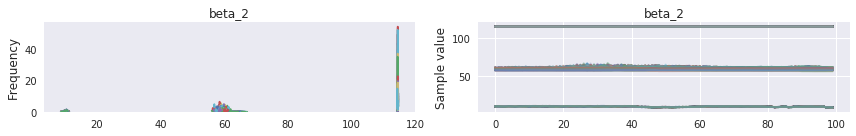

In [37]:
#pm.traceplot(trace[900:], varnames=['beta_0','beta_1','beta_2','beta_4','beta_3','beta_5'])
#pm.traceplot(trace[:], varnames=['mu_beta_1','mu_beta_4',])
pm.traceplot(trace[900:], varnames=['beta_2'])

#start

Text(0.5,1,'2017-05-04 06:40:00')

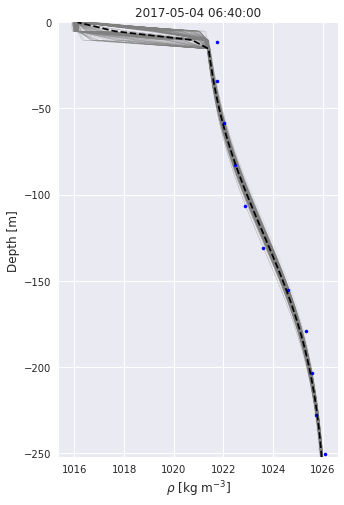

In [38]:
tstep = -10
#rhomean = double_tanh([params['mean']['beta_%d__%d'%(ii,tstep)] for ii in range(6)], zout)
rhomean = np.zeros_like(zout)

#plt.plot(rhomean, zout, 'k--',)

#plt.fill_betweenx(depths, \
#        ppc['y'].mean(axis=0)- ppc['y'].std(axis=0),\
#        ppc['y'].mean(axis=0)+ppc['y'].std(axis=0),
#        color='0.5',alpha=0.2)

#def my_model(x,y):
#    return lin_model([y['beta_0'],y['beta_1']],x)
#pm.plot_posterior_predictive_glm(trace, eval=zout, lm=my_model)

plt.figure(figsize=(5,8))
samples = 500
for rand_loc in np.random.randint(0, len(trace), samples):
    rs = trace[rand_loc]
    rhotmp = double_tanh([rs['beta_%d'%ii][tstep] for ii in range(6)], zout)
    plt.plot(rhotmp, zout, '0.5', lw=0.2, alpha=0.5)
    
    rhomean+=rhotmp
    
plt.plot(rho_obs_2d[tstep,:],depths_2d[tstep,:], 'b.')

rhomean /= samples
plt.plot(rhomean, zout, 'k--',) # Mean fit

plt.ylim(zmin,0 )
plt.ylabel('Depth [m]')
plt.xlabel(r'$\rho$ [kg m$^{-3}$]')
plt.title(time[tstep])

#plt.savefig('pymc3_crux_fit_%d.png'%tstep)
#plt.savefig('pymc3_crux_fit_%d.pdf'%tstep)


In [59]:
# Save to hdf


# Single-tanh function

In [213]:
# Full model
with pm.Model() as rho_model:
    ###
    # Create priors for each of our means
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    # Use a dictionary so we can look up the parameters easily
    mu_betas = dict(
        mu_beta_0 = pm.Normal('mu_beta_0', mu=1025.0, sd=10.0,),
        mu_beta_1 = BoundedNormal('mu_beta_1', mu=1., sd=0.5,),
        mu_beta_2 = BoundedNormal('mu_beta_2', mu=75.0, sd=15.0,),
        mu_beta_3 = BoundedNormal('mu_beta_3', mu=80.0, sd=15.0,),

    )
    
    nparams=4
    sigma_beta = pm.HalfNormal('sigma_beta', sd=15.0, shape=(nparams,))
    sigma_curve = pm.HalfNormal('sigma_curve', sd=0.25 )


    beta_s = []
    for ii in range(nparams):
        if ii in [1,2,3]:
                # Replace beta_1 and beta_4 with bounds
            beta_s.append(BoundedNormal('beta_%d'%ii,\
                    mu=mu_betas['mu_beta_%d'%ii], sd=sigma_beta[ii], shape=(nt,)))
        else:
            beta_s.append(pm.Normal('beta_%d'%ii,\
                mu=mu_betas['mu_beta_%d'%ii], sd=sigma_beta[ii], shape=(nt,)))
    

    ###
    # Generate the likelihood function using the deterministic variable as the mean
    mu_x = single_tanh_pm(beta_s, depths_2d.T)
    
    #rho = pm.Normal('rho', mu=mu_x, sd=sigma_curve, observed=rho_obs_2d.T, shape=(nt,))
    #rho = pm.Normal('rho', mu=mu_x, sd=sigma_curve, observed=rho_obs_2d.T, shape=(nz,))
    rho = pm.Normal('rho', mu=mu_x, sd=sigma_curve, observed=rho_obs_2d.T, shape=(nt,nz))
    #rho = pm.Normal('rho', mu=mu_x, sd=sigma_curve, observed=rho_obs_2d.T)

    
    ###
    # Inference step
    #start = pm.find_MAP()
    step = pm.NUTS(target_accept=0.80)
    #step = None
    trace = pm.sample(1000, tune=2500, step=step, cores=2)
    
#rho_model

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_3_lowerbound__, beta_2_lowerbound__, beta_1_lowerbound__, beta_0, sigma_curve_log__, sigma_beta_log__, mu_beta_3_lowerbound__, mu_beta_2_lowerbound__, mu_beta_1_lowerbound__, mu_beta_0]
100%|██████████| 3500/3500 [05:33<00:00, 10.48it/s]
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9947434407441684, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [214]:
params = pm.summary(trace)
params[0:5]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_beta_0,1023.586247,0.013604,0.001277,1023.555386,1023.611975,5.121743,1.155561
beta_0__0,1023.613380,0.048877,0.004268,1023.556208,1023.735058,4.713179,1.216869
beta_0__1,1023.611815,0.047040,0.004165,1023.549566,1023.731513,5.171173,1.197849
beta_0__2,1023.609812,0.043799,0.003706,1023.556707,1023.720097,5.213530,1.193547
beta_0__3,1023.606815,0.040441,0.003375,1023.552318,1023.714734,5.998647,1.156539


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e6a414ac8>,
      dtype=object)

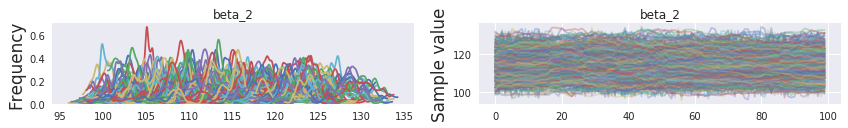

In [215]:
pm.traceplot(trace[900:], varnames=['beta_2'])

Text(0.5,1,'2017-05-06 12:40:00')

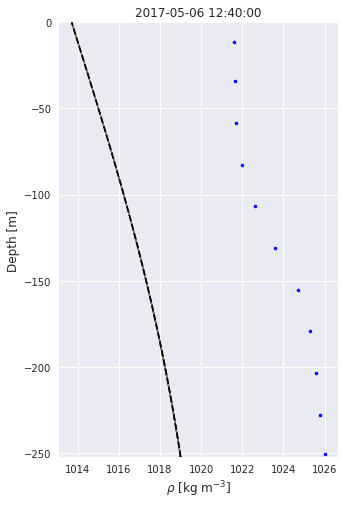

In [147]:
tstep = -1
#rhomean = double_tanh([params['mean']['beta_%d__%d'%(ii,tstep)] for ii in range(6)], zout)
rhomean = np.zeros_like(zout)


plt.figure(figsize=(5,8))
samples = 500
for rand_loc in np.random.randint(0, len(trace), samples):
    rs = trace[rand_loc]
    rhotmp = single_tanh([rs['beta_%d'%ii][tstep] for ii in range(4)], zout)
    plt.plot(rhotmp, zout, '0.5', lw=0.2, alpha=0.5)
    
    rhomean+=rhotmp
    
plt.plot(rho_obs_2d[tstep,:],depths_2d[tstep,:], 'b.')

rhomean /= samples
plt.plot(rhomean, zout, 'k--',) # Mean fit

plt.ylim(zmin,0 )
plt.ylabel('Depth [m]')
plt.xlabel(r'$\rho$ [kg m$^{-3}$]')
plt.title(time[tstep])

# Old stuff...

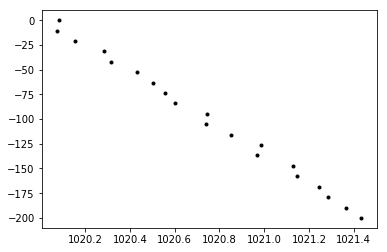

In [89]:
# Create some fake data for testing
k = 20
depths = np.linspace(0,-200, k)

rho_obs = 1020 - 0.007*depths + 0.1*np.random.rand(20,)

plt.plot(rho_obs, depths, 'k.')


In [12]:
# Perform the inference
with rho_model:
    #start = pm.find_MAP(model=sst_model)
    start=None
    
    #step = pm.Metropolis()
    # NUTS: No U-Turn Sample
    step = pm.NUTS()
    
    #step = pm.HamiltonianMC()
    
    trace = pm.sample(1000, tune=900, start = start, step=step, cores=2)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_curve, beta_5, beta_4, beta_3, beta_2, beta_1, beta_0, sigma_beta, mu_beta_5, mu_beta_4, mu_beta_3, mu_beta_2, mu_beta_1, mu_beta_0]
  0%|          | 0/1900 [00:00<?, ?it/s]


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7ff7e67c1930, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/suntans/.conda/envs/soda/lib/python3.6/sit...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/suntan.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7ff7e67c1930, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/suntans/.conda/envs/soda/lib/python3.6/sit...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/suntan.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Perform the inference\nwith rho_model:\n    #sta...000, tune=900, start = start, step=step, cores=2)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 7, 10, 8, 49, 35, 246479, tzinfo=tzutc()), 'msg_id': '3b114fac050542f388d15d19a465d592', 'msg_type': 'execute_request', 'session': '02824009959e456496c0efbf8570f9d2', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '3b114fac050542f388d15d19a465d592', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'02824009959e456496c0efbf8570f9d2']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# Perform the inference\nwith rho_model:\n    #sta...000, tune=900, start = start, step=step, cores=2)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 7, 10, 8, 49, 35, 246479, tzinfo=tzutc()), 'msg_id': '3b114fac050542f388d15d19a465d592', 'msg_type': 'execute_request', 'session': '02824009959e456496c0efbf8570f9d2', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '3b114fac050542f388d15d19a465d592', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'02824009959e456496c0efbf8570f9d2'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Perform the inference\nwith rho_model:\n    #sta...000, tune=900, start = start, step=step, cores=2)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 7, 10, 8, 49, 35, 246479, tzinfo=tzutc()), 'msg_id': '3b114fac050542f388d15d19a465d592', 'msg_type': 'execute_request', 'session': '02824009959e456496c0efbf8570f9d2', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '3b114fac050542f388d15d19a465d592', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# Perform the inference\nwith rho_model:\n    #sta...000, tune=900, start = start, step=step, cores=2)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# Perform the inference\nwith rho_model:\n    #sta...000, tune=900, start = start, step=step, cores=2)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# Perform the inference\nwith rho_model:\n    #sta...000, tune=900, start = start, step=step, cores=2)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# Perform the inference\nwith rho_model:\n    #sta...000, tune=900, start = start, step=step, cores=2)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# Perform the inference\nwith rho_model:\n    #sta...000, tune=900, start = start, step=step, cores=2)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.With object>], cell_name='<ipython-input-12-07a6904c7887>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7ff78ea4c2b0, executi..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7ff78e5ce0c0, file "<ipython-input-12-07a6904c7887>", line 2>
        result = <ExecutionResult object at 7ff78ea4c2b0, executi..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7ff78e5ce0c0, file "<ipython-input-12-07a6904c7887>", line 2>, result=<ExecutionResult object at 7ff78ea4c2b0, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7ff78e5ce0c0, file "<ipython-input-12-07a6904c7887>", line 2>
        self.user_global_ns = {'In': ['', "import pymc3 as pm\nimport numpy as np\nimport pan..._ipython().run_line_magic('matplotlib', 'inline')", '# Our model\ndef double_tanh_pm(beta, z):\n    \n  ...     + np.tanh((z+beta[2]+beta[4])/beta[5]))\n    ', "# Load some density data\ncsvfile = '/home/suntan...ead_csv(csvfile, index_col=0, sep=', ')\ndf.tail()", "# Get the depths and density values out of the d...7, 70.,20.,80.,30.], depths),depths,'r.')\nrho_obs", "with pm.Model() as rho_model:\n    ###\n    # Crea...'rho', mu=mu_x, sd=sigma_curve, observed=rho_obs)", '# Perform the inference\nwith rho_model:\n    #sta...000, tune=900, start = start, step=step, cores=2)', '# Model with "no time component"\n\nwith pm.Model(...000, tune=900, start = start, step=step, cores=2)', "import pymc3 as pm\nimport numpy as np\nimport pan..._ipython().run_line_magic('matplotlib', 'inline')", "my_depths = shared(depths)\n\nwith pm.Model() as r...'rho', mu=mu_x, sd=sigma_curve, observed=rho_obs)", "my_depths = shared(depths)\n\nwith pm.Model() as r...'rho', mu=mu_x, sd=sigma_curve, observed=rho_obs)", 'map_estimate = pm.find_MAP(model=rho_model)\n\nprint(map_estimate)', '# Perform the inference\nwith rho_model:\n    #sta...000, tune=900, start = start, step=step, cores=2)'], 'Out': {3:                     -31.0     -39.0 -49.0     -5...13-07-23T00:00:01  1025.467       nan  1025.890  , 4: array([1021.663, 1021.674, 1021.721, 1021.817, 1..., 1022.914, 1023.39 ,
       1024.228, 1025.144])}, '_': array([1021.663, 1021.674, 1021.721, 1021.817, 1..., 1022.914, 1023.39 ,
       1024.228, 1025.144]), '_3':                     -31.0     -39.0 -49.0     -5...13-07-23T00:00:01  1025.467       nan  1025.890  , '_4': array([1021.663, 1021.674, 1021.721, 1021.817, 1..., 1022.914, 1023.39 ,
       1024.228, 1025.144]), '__':                     -31.0     -39.0 -49.0     -5...13-07-23T00:00:01  1025.467       nan  1025.890  , '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}
        self.user_ns = {'In': ['', "import pymc3 as pm\nimport numpy as np\nimport pan..._ipython().run_line_magic('matplotlib', 'inline')", '# Our model\ndef double_tanh_pm(beta, z):\n    \n  ...     + np.tanh((z+beta[2]+beta[4])/beta[5]))\n    ', "# Load some density data\ncsvfile = '/home/suntan...ead_csv(csvfile, index_col=0, sep=', ')\ndf.tail()", "# Get the depths and density values out of the d...7, 70.,20.,80.,30.], depths),depths,'r.')\nrho_obs", "with pm.Model() as rho_model:\n    ###\n    # Crea...'rho', mu=mu_x, sd=sigma_curve, observed=rho_obs)", '# Perform the inference\nwith rho_model:\n    #sta...000, tune=900, start = start, step=step, cores=2)', '# Model with "no time component"\n\nwith pm.Model(...000, tune=900, start = start, step=step, cores=2)', "import pymc3 as pm\nimport numpy as np\nimport pan..._ipython().run_line_magic('matplotlib', 'inline')", "my_depths = shared(depths)\n\nwith pm.Model() as r...'rho', mu=mu_x, sd=sigma_curve, observed=rho_obs)", "my_depths = shared(depths)\n\nwith pm.Model() as r...'rho', mu=mu_x, sd=sigma_curve, observed=rho_obs)", 'map_estimate = pm.find_MAP(model=rho_model)\n\nprint(map_estimate)', '# Perform the inference\nwith rho_model:\n    #sta...000, tune=900, start = start, step=step, cores=2)'], 'Out': {3:                     -31.0     -39.0 -49.0     -5...13-07-23T00:00:01  1025.467       nan  1025.890  , 4: array([1021.663, 1021.674, 1021.721, 1021.817, 1..., 1022.914, 1023.39 ,
       1024.228, 1025.144])}, '_': array([1021.663, 1021.674, 1021.721, 1021.817, 1..., 1022.914, 1023.39 ,
       1024.228, 1025.144]), '_3':                     -31.0     -39.0 -49.0     -5...13-07-23T00:00:01  1025.467       nan  1025.890  , '_4': array([1021.663, 1021.674, 1021.721, 1021.817, 1..., 1022.914, 1023.39 ,
       1024.228, 1025.144]), '__':                     -31.0     -39.0 -49.0     -5...13-07-23T00:00:01  1025.467       nan  1025.890  , '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/suntans/Share/ARCHub/MODELLING/DensityFitting/<ipython-input-12-07a6904c7887> in <module>()
      7     # NUTS: No U-Turn Sample
      8     step = pm.NUTS()
      9     
     10     #step = pm.HamiltonianMC()
     11     
---> 12     trace = pm.sample(1000, tune=900, start = start, step=step, cores=2)

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/pymc3/sampling.py in sample(draws=1900, step=<pymc3.step_methods.hmc.nuts.NUTS object>, init='auto', n_init=200000, start=[{}, {}], trace=None, chain_idx=0, chains=2, cores=2, tune=900, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=[104573924, 24689083], live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, use_mmap=False, **kwargs={})
    437     parallel = cores > 1 and chains > 1 and not has_population_samplers
    438     if parallel:
    439         _log.info('Multiprocess sampling ({} chains in {} jobs)'.format(chains, cores))
    440         _print_step_hierarchy(step)
    441         try:
--> 442             trace = _mp_sample(**sample_args)
        trace = None
        sample_args = {'chain': 0, 'chains': 2, 'cores': 2, 'draws': 1900, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'progressbar': True, 'random_seed': [104573924, 24689083], 'start': [{}, {}], ...}
    443         except pickle.PickleError:
    444             _log.warning("Could not pickle model, sampling singlethreaded.")
    445             _log.debug('Pickling error:', exec_info=True)
    446             parallel = False

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/pymc3/sampling.py in _mp_sample(**kwargs={'draws': 1900, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 900})
    977             for args in zip(chain_nums, pbars, rseed, start))
    978 
    979     if use_mmap:
    980         traces = Parallel(n_jobs=cores)(jobs)
    981     else:
--> 982         traces = Parallel(n_jobs=cores, mmap_mode=None)(jobs)
        traces = undefined
        cores = 2
        jobs = <generator object _mp_sample.<locals>.<genexpr>>
    983 
    984     return MultiTrace(traces)
    985 
    986 

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object _mp_sample.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Tue Jul 10 16:49:39 2018
PID: 13305          Python 3.6.4: /home/suntans/.conda/envs/soda/bin/python
...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _sample>, (0, True, 104573924, {'beta_0': array(1025.), 'beta_1': array(5.), 'beta_2': array(75.), 'beta_3': array(80.), 'beta_4': array(75.), 'beta_5': array(80.), 'mu_beta_0': array(1025.), 'mu_beta_1': array(5.), 'mu_beta_2': array(75.), 'mu_beta_3': array(80.), ...}), {'draws': 1900, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 900})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = (0, True, 104573924, {'beta_0': array(1025.), 'beta_1': array(5.), 'beta_2': array(75.), 'beta_3': array(80.), 'beta_4': array(75.), 'beta_5': array(80.), 'mu_beta_0': array(1025.), 'mu_beta_1': array(5.), 'mu_beta_2': array(75.), 'mu_beta_3': array(80.), ...})
        kwargs = {'draws': 1900, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 900}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/pymc3/sampling.py in _sample(chain=0, progressbar=True, random_seed=104573924, start={'beta_0': array(1025.), 'beta_1': array(5.), 'beta_2': array(75.), 'beta_3': array(80.), 'beta_4': array(75.), 'beta_5': array(80.), 'mu_beta_0': array(1025.), 'mu_beta_1': array(5.), 'mu_beta_2': array(75.), 'mu_beta_3': array(80.), ...}, draws=1900, step=<pymc3.step_methods.hmc.nuts.NUTS object>, trace=None, tune=900, model=<pymc3.model.Model object>, live_plot=False, live_plot_kwargs=None, **kwargs={})
    549                             tune, model, random_seed)
    550     if progressbar:
    551         sampling = tqdm(sampling, total=draws)
    552     try:
    553         strace = None
--> 554         for it, strace in enumerate(sampling):
        it = undefined
        strace = None
        sampling =   0%|          | 0/1900 [00:00<?, ?it/s]
    555             if live_plot:
    556                 if live_plot_kwargs is None:
    557                     live_plot_kwargs = {}
    558                 if it >= skip_first:

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/tqdm/_tqdm.py in __iter__(self=  0%|          | 0/1900 [00:00<?, ?it/s])
    925             except AttributeError:
    926                 raise TqdmDeprecationWarning("""\
    927 Please use `tqdm_gui(...)` instead of `tqdm(..., gui=True)`
    928 """, fp_write=getattr(self.fp, 'write', sys.stderr.write))
    929 
--> 930             for obj in iterable:
        obj = undefined
        iterable = <generator object _iter_sample>
    931                 yield obj
    932                 # Update and possibly print the progressbar.
    933                 # Note: does not call self.update(1) for speed optimisation.
    934                 n += 1

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/pymc3/sampling.py in _iter_sample(draws=1900, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'beta_0': array(1025.), 'beta_1': array(5.), 'beta_2': array(75.), 'beta_3': array(80.), 'beta_4': array(75.), 'beta_5': array(80.), 'mu_beta_0': array(1025.), 'mu_beta_1': array(5.), 'mu_beta_2': array(75.), 'mu_beta_3': array(80.), ...}, trace=None, chain=0, tune=900, model=<pymc3.model.Model object>, random_seed=104573924)
    647         step.tune = bool(tune)
    648         for i in range(draws):
    649             if i == tune:
    650                 step = stop_tuning(step)
    651             if step.generates_stats:
--> 652                 point, states = step.step(point)
        point = {'beta_0': array(1025.), 'beta_1': array(5.), 'beta_2': array(75.), 'beta_3': array(80.), 'beta_4': array(75.), 'beta_5': array(80.), 'mu_beta_0': array(1025.), 'mu_beta_1': array(5.), 'mu_beta_2': array(75.), 'mu_beta_3': array(80.), ...}
        states = undefined
        step.step = <bound method GradientSharedStep.step of <pymc3.step_methods.hmc.nuts.NUTS object>>
    653                 if strace.supports_sampler_stats:
    654                     strace.record(point, states)
    655                 else:
    656                     strace.record(point)

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/pymc3/step_methods/arraystep.py in step(self=<pymc3.step_methods.hmc.nuts.NUTS object>, point={'beta_0': array(1025.), 'beta_1': array(5.), 'beta_2': array(75.), 'beta_3': array(80.), 'beta_4': array(75.), 'beta_5': array(80.), 'mu_beta_0': array(1025.), 'mu_beta_1': array(5.), 'mu_beta_2': array(75.), 'mu_beta_3': array(80.), ...})
    217     def step(self, point):
    218         self._logp_dlogp_func.set_extra_values(point)
    219         array = self._logp_dlogp_func.dict_to_array(point)
    220 
    221         if self.generates_stats:
--> 222             apoint, stats = self.astep(array)
        apoint = undefined
        stats = undefined
        self.astep = <bound method BaseHMC.astep of <pymc3.step_methods.hmc.nuts.NUTS object>>
        array = array([   0.,   80.,   75.,   80.,   75.,    5.,...  80.,
         75.,   80.,   75.,    5., 1025.])
    223             point = self._logp_dlogp_func.array_to_full_dict(apoint)
    224             return point, stats
    225         else:
    226             apoint = self.astep(array)

...........................................................................
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/pymc3/step_methods/hmc/base_hmc.py in astep(self=<pymc3.step_methods.hmc.nuts.NUTS object>, q0=array([   0.,   80.,   75.,   80.,   75.,    5.,...  80.,
         75.,   80.,   75.,    5., 1025.]))
    112         start = self.integrator.compute_state(q0, p0)
    113 
    114         if not np.isfinite(start.energy):
    115             self.potential.raise_ok()
    116             raise ValueError('Bad initial energy: %s. The model '
--> 117                              'might be misspecified.' % start.energy)
        start.energy = inf
    118 
    119         adapt_step = self.tune and self.adapt_step_size
    120         step_size = self.step_adapt.current(adapt_step)
    121         self.step_size = step_size

ValueError: Bad initial energy: inf. The model might be misspecified.
___________________________________________________________________________

In [18]:
# Print a summary of the parameters

print(beta_real)

pm.summary(trace)

[23.0, 2e-05, 2.3, 1.2, 0.3, 0.5, 0.1, 0.003]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_mean,22.999821,0.010095,2.366334e-04,22.980322,23.019662,2110.998042,1.000108
beta_linear,0.000021,0.000002,4.163731e-08,0.000017,0.000024,2321.009629,1.001698
beta_0_re,2.296992,0.007537,1.437369e-04,2.283246,2.312877,3056.472020,0.999512
beta_0_im,1.200659,0.007256,1.186847e-04,1.186465,1.214851,3219.960286,0.999624
beta_1_re,0.297990,0.007803,1.260276e-04,0.281848,0.312350,3580.866463,0.999851
beta_1_im,0.512436,0.007487,1.302984e-04,0.498397,0.526955,3434.666898,0.999715
beta_2_re,0.102420,0.007689,1.228060e-04,0.086447,0.116098,3983.447389,0.999880
beta_2_im,0.002625,0.007348,1.278530e-04,-0.011264,0.017126,3587.900722,0.999514
sigma,0.500753,0.003601,5.593779e-05,0.493370,0.507480,3359.040424,0.999928


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd180142438>,
      dtype=object)

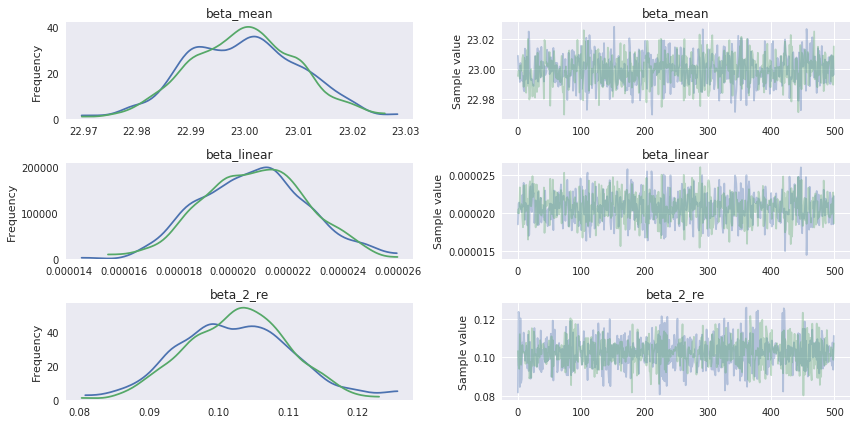

In [20]:
pm.traceplot(trace[500:], varnames=['beta_mean','beta_linear', 'beta_2_re'])

In [30]:
# Plot the uncertainty bounds of the estimated data


# Get samples like this
ppc = pm.sample_ppc(trace, model=sst_model, samples=500)

sst_est = ppc.values




100%|██████████| 500/500 [00:00<00:00, 1045.90it/s]


In [36]:
trace['beta_linear'].shape

(2000,)

(0, 1000)

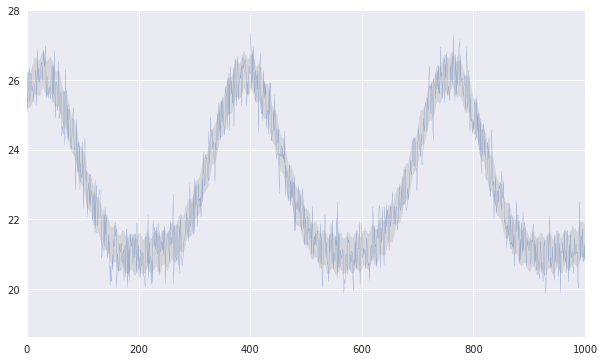

In [23]:
plt.figure(figsize=(10,6))

plt.fill_between(time/tday, \
        sst_est.mean(axis=0)- sst_est.std(axis=0),\
        sst_est.mean(axis=0)+sst_est.std(axis=0),
        color='0.5',alpha=0.2)
plt.plot(time/tday, ssh_real, lw=0.2, alpha=0.9)
plt.xlim(0,1000)

In [22]:
pm.summary?

In [50]:
# Get the mean and quantiles of the model parameters

def trace_sd(x):
    return pd.Series(np.std(x, 0), name='sd')
def trace_mean(x):
    return pd.Series(np.mean(x, 0), name='mean')
def trace_quantiles(x):
    return pd.DataFrame(pm.quantiles(x, [5, 50, 95]))

params = pm.summary(trace, stat_funcs=[trace_mean, trace_sd, trace_quantiles])
params

,mean,sd,5,50,95
beta_mean,22.980459,0.020916,22.945047,22.980331,23.014957
beta_linear,0.000023,0.000004,0.000016,0.000023,0.000029
beta_0_re,2.291897,0.014990,2.267137,2.291973,2.317422
beta_0_im,1.208540,0.014815,1.183837,1.208696,1.233391
beta_1_re,0.303794,0.014611,0.279941,0.304099,0.327865
beta_1_im,0.504294,0.014964,0.480597,0.504409,0.529109
beta_2_re,0.111250,0.014782,0.086851,0.111417,0.135911
beta_2_im,-0.000278,0.015209,-0.025068,-0.000930,0.025166


In [52]:
params[50]['beta_linear']

2.2577274008343285e-05

X_obs

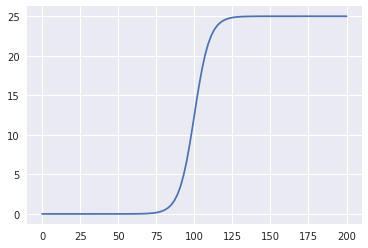

In [8]:
def weight_tanh_dist(dist,maxdist):
    return 0.5+0.5*np.tanh( (dist-0.5*maxdist) / (0.17*maxdist) )

def return_depth(x, x0, l_s, h0):
    return 0.5*h0*(1 + np.tanh( (x-x0) / (0.5*l_s) ))


maxdist = 100.
X = np.linspace(0,2*maxdist,100)
#plt.plot(X, weight_tanh_dist(X, maxdist))

plt.plot(X, return_depth(X, 100, 20., 25.))